# Convolutional Neural Network (CNN) for Jet Image Classification

In this section, a Convolutional Neural Network (CNN) is implemented to classify jets as either originating from QCD background or from Higgs boson decays (H → bb̄). Each jet is represented as a 2D image constructed from its constituent particles using the p<sub>T</sub>, η, and φ information:

p<sub>T</sub> (used as pixel intensity)

η<sub>rel</sub>, φ<sub>rel</sub> (used as pixel positions)

Jet images are generated using 2D histograms with configurable bin sizes. The CNN model processes these images through multiple convolutional, pooling, and dense layers. The model is trained using mass and p<sub>T</sub> filtered jets:

Mass window: 40 GeV < M<sub>sd</sub> < 200 GeV

Transverse momentum: 300 GeV < p<sub>T</sub> < 2000 GeV

Model performance is evaluated with the ROC curve and AUC score to assess classification effectiveness.

In [1]:
# ============================
# Core Numerical & I/O Libraries
# ============================
import numpy as np
import uproot
import fsspec_xrootd  # For remote file access (XRootD)

# ============================
# TensorFlow / Keras (Model Building)
# ============================
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, BatchNormalization,
    Flatten, MaxPooling2D, Activation, Dropout
)
import tensorflow.keras.backend as K

# ============================
# Keras Callbacks
# ============================
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

# ============================
# Evaluation Metrics
# ============================
from sklearn.metrics import roc_curve, auc

# ============================
# Utility Modules
# ============================
import utilities.utils as utils
from utilities.utils import find_nearest
import yaml

# ============================
# Plotting
# ============================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
plt.style.use(hep.style.ROOT)  # CMS/ROOT-style plots


2025-07-08 08:18:52.921147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 08:18:52.929526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751962732.944775   66437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751962732.947738   66437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751962732.961995   66437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Running on:", tf.config.list_physical_devices())

Running on: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-07-08 08:18:54.420216: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
with open('./utilities/definitions_cnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nlabels = definitions['nlabels']
nspectators = definitions['nspectators']

In [4]:
# =========================================
# Define paths to input ROOT files
# =========================================
root_data = {
    'train_data': "/home/sashi/predoc project/project/ntuple_merged_10.root",
    'val_data'  : "/home/sashi/predoc project/project/ntuple_merged_11.root",
    'test_data' : "/home/sashi/predoc project/project/ntuple_merged_0.root",
}

# =========================================
# Load training data
# - Applies mass and pT cuts
# - Retrieves features, labels, and spectators
# =========================================
feature_array, label, spec_array = utils.get_features_labels(
    root_data['train_data'],
    features,
    spectators,
    labels,
    remove_mass_pt_window=True,
    entry_stop=5000
)

# =========================================
# Load validation data (used for model tuning)
# =========================================
feature_array_val, label_val, spec_array_val = utils.get_features_labels(
    root_data['val_data'],
    features,
    spectators,
    labels,
    remove_mass_pt_window=True,
    entry_stop=4000
)

# =========================================
# Load test data (used for final performance evaluation)
# =========================================
feature_array_test, label_array_test, spec_array_test = utils.get_features_labels(
    root_data['test_data'],
    features,
    spectators,
    labels,
    remove_mass_pt_window=True,
    entry_stop=5000
)

In [5]:
# ===========================================================
# Convert particle-level feature arrays into 2D images
# (ptrel-weighted η–φ maps) using histogram projection
# ===========================================================
img_array      = utils.make_image(feature_array)       # Training images
img_array_val  = utils.make_image(feature_array_val)   # Validation images
img_array_test = utils.make_image(feature_array_test)  # Test images

# ===========================================================
# Retrieve image shape for CNN input:
# Each image has shape (rows, columns, channels)
# Typically: (224, 224, 1)
# ===========================================================
row, col, h = img_array[0].shape

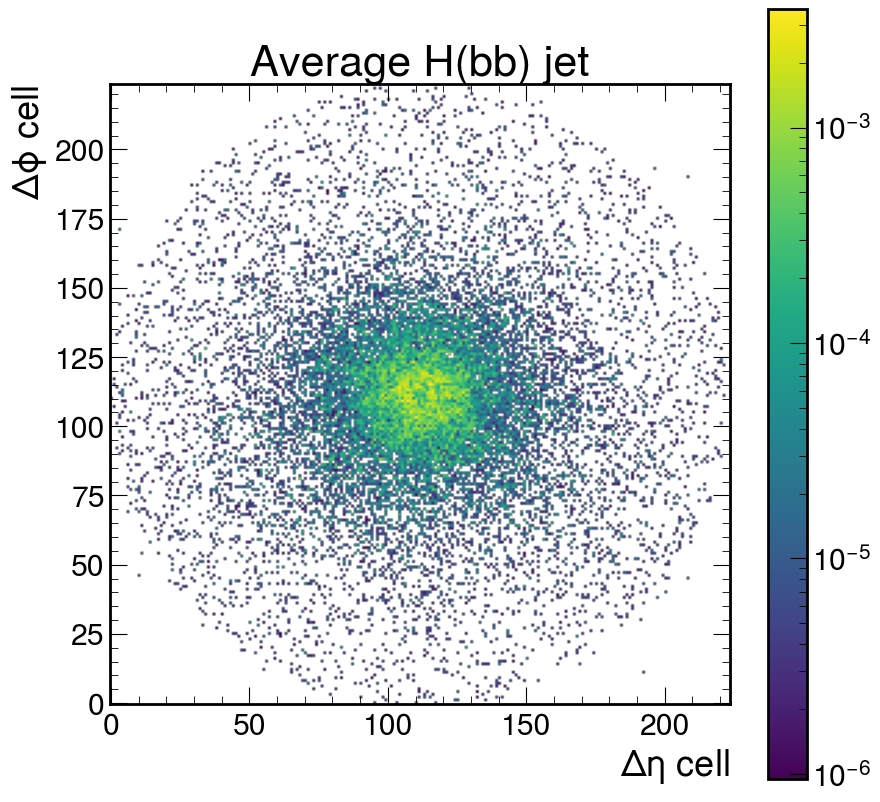

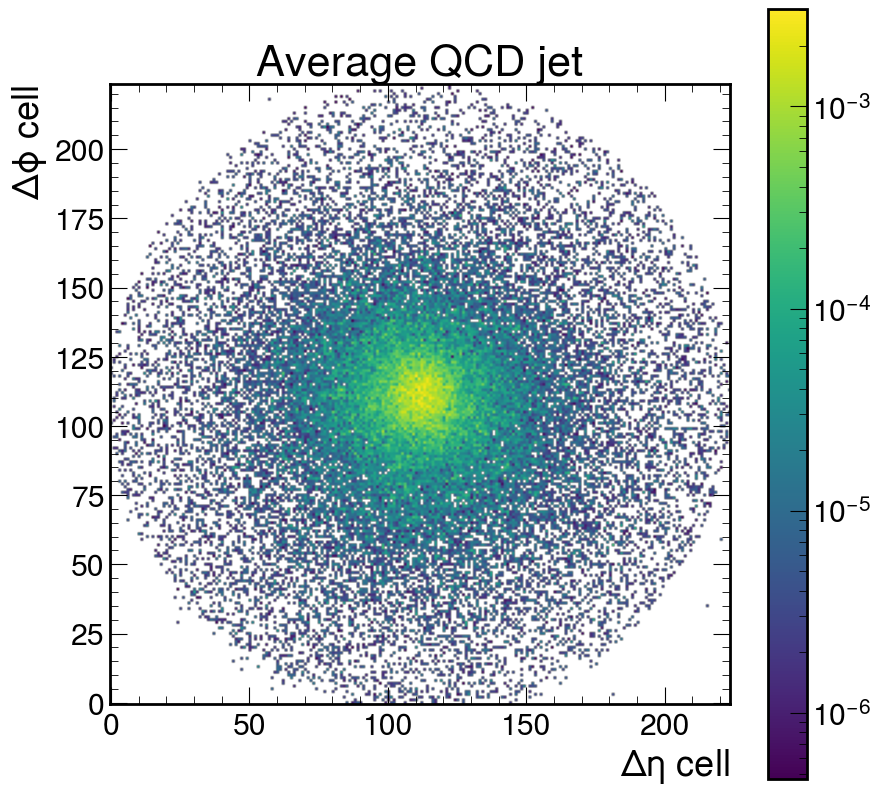

In [6]:
# For Signal
plt.figure()
plt.title('Average H(bb) jet')
plt.imshow(np.mean(img_array[label[:, 1] == 1], axis = 0), norm = LogNorm(), origin = 'lower')
plt.colorbar()
plt.xlabel('$\Delta \eta$ cell')
plt.ylabel('$\Delta \phi$ cell')
plt.show()

# For QCD Background
plt.figure()
plt.title('Average QCD jet')
plt.imshow(np.mean(img_array[label[:, 0] == 1], axis = 0), norm = LogNorm(), origin = 'lower')
plt.xlabel('$\Delta \eta$ cell')
plt.ylabel('$\Delta \phi$ cell')
plt.colorbar()
plt.show()

In [7]:
# ===============================================
# Define a CNN model for jet image classification
# ===============================================

# Input layer: Accepts 2D image of shape (η, φ, 1)
inputs = Input(shape=img_array[0].shape, name='input')

# First normalization layer to stabilize training
x = BatchNormalization(name='bn_1')(inputs)

# -------------------------------
# First Convolutional Block
# -------------------------------
x = Conv2D(64, (3, 3), name='conv_1', padding='same')(x)  # 64 filters, 3x3 kernel
x = Dropout(0.2)(x)                                       # Dropout for regularization
x = MaxPooling2D(pool_size=(2, 2))(x)                      # Downsample the feature map
x = BatchNormalization(name='bn_2')(x)
x = Activation('relu')(x)                                 # Non-linear activation

# -------------------------------
# Second Convolutional Block
# -------------------------------
x = Conv2D(32, (3, 3), padding='same', name='conv_2')(x)   # 32 filters
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization(name='bn_3')(x)
x = Activation('relu')(x)

# -------------------------------
# Dense Output Head
# -------------------------------
x = Flatten(name='flatten_1')(x)                          # Flatten before dense layers
x = Dense(256, activation='relu', name='dense_1')(x)      # Fully connected layer
outputs = Dense(nlabels, activation='softmax', name='dense_2')(x)  # Output layer for classification

# -------------------------------
# Compile the model
# -------------------------------
conv_model = Model(inputs=inputs, outputs=outputs)
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
print(conv_model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 224, 224, 1)    │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 56, 56, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,710,374 (98.08 MB)

 Trainable params: 25,710,180 (98.08 MB)

 Non-trainable params: 194 (776.00 B)

None


In [8]:
# ============================================================
# Set up callbacks for better training management
# ============================================================

# Save best model (based on validation loss)
model_checks = ModelCheckpoint(
    filepath='./trained_models/new_models/keras_model_best_cnn.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Stop training early if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5
)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5
)

# Combine callbacks into a list
callbacks = [model_checks, early_stop, reduce_lr]

# ============================================================
# Train the CNN model on jet images
# ============================================================

conv_model_history = conv_model.fit(
    img_array,                      # Training images
    label,                          # Corresponding labels
    validation_data=(img_array_val, label_val),  # Validation set
    epochs=30,                      # Max number of epochs
    shuffle=True,                   # Shuffle training data
    callbacks=callbacks             # Use callbacks for training control
)

# Load best model weights (if not already loaded)
# conv_model.load_weights('keras_model_conv_2d.keras')

# Save the full model to disk
# conv_model.save('./models/cnn/keras_model_conv_2d.keras')

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - accuracy: 0.5854 - loss: 2.6338 - val_accuracy: 0.6843 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.7594 - loss: 0.5182 - val_accuracy: 0.3157 - val_loss: 0.7821 - learning_rate: 0.0010
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.8259 - loss: 0.3922 - val_accuracy: 0.3157 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.8858 - loss: 0.2520 - val_accuracy: 0.6820 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - accuracy: 0.9403 - loss: 0.1519 - val_accuracy: 0.3211 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.9636 - loss: 0.1058 - val_accuracy: 0.4178 - val_loss: 0.7001 - learning_rate: 5.0000e-04


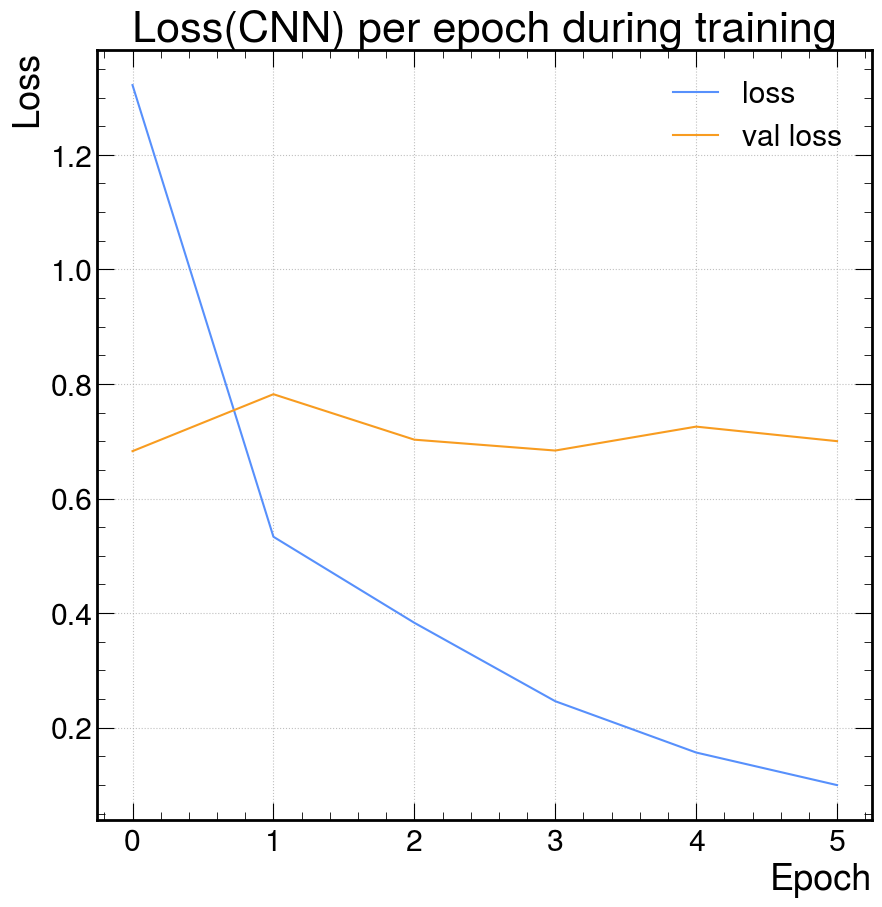

In [9]:
# Loss per epoch plot
plt.figure()
plt.plot(conv_model_history.history['loss'], label = 'loss')
plt.plot(conv_model_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss(CNN) per epoch during training')
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


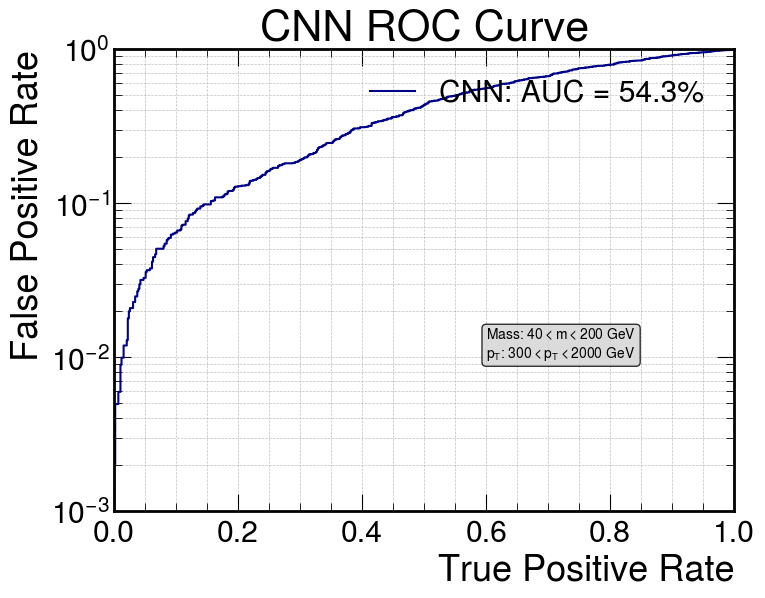

In [14]:
from matplotlib.patches import FancyBboxPatch

# Get predictions from the CNN model
predict_array_cnn2d = conv_model.predict(img_array_test)

# Compute ROC curve
fpr_cnn2d, tpr_cnn2d, threshold_cnn2d = roc_curve(label_array_test[:, 1], predict_array_cnn2d[:, 1])

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(tpr_cnn2d, fpr_cnn2d, label=f"CNN: AUC = {auc(fpr_cnn2d, tpr_cnn2d)*100:.1f}%", color='darkblue')

# Use logarithmic scale on y-axis
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.001, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Axis labels and title
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('CNN ROC Curve')
plt.legend(loc='upper right')

# Box with applied selection cuts
cut_text = r"Mass: $40 < m < 200$ GeV" + "\n" + r"$p_T$: $300 < p_T < 2000$ GeV"
props = dict(boxstyle='round,pad=0.3', facecolor='lightgray', edgecolor='black', alpha=0.8)
plt.text(0.6, 0.01, cut_text, fontsize=10, bbox=props)

plt.show()
